In [46]:
import requests
from bs4 import BeautifulSoup
import bs4
import pandas as pd
import os

In [47]:
import time

In [75]:

def extract_tables(soup):
    """
    Extract all tables from BeautifulSoup object
    Returns a list of pandas DataFrames, each representing a table
    """
    dataframes = []
    
    # Find all table elements
    table_elements = soup.find_all('table')
    
    for i, table in enumerate(table_elements):
        headers = []
        rows = []
        
        # Extract headers
        header_elements = table.find_all('th')
        if header_elements:
            headers = [header.get_text(strip=True) for header in header_elements]
        else:
            # If no th elements, try to get headers from first tr
            first_row = table.find('tr')
            if first_row:
                first_row_cells = first_row.find_all(['td', 'th'])
                headers = [cell.get_text(strip=True) for cell in first_row_cells]
        
        # Extract all rows
        row_elements = table.find_all('tr')
        for row in row_elements:
            cells = row.find_all(['td', 'th'])
            if cells:
                row_data = [cell.get_text(strip=True) for cell in cells]
                # Skip if this row was used as headers
                if row_data != headers:
                    rows.append(row_data)
        
        # Create DataFrame
        if rows:
            if headers and len(headers) == len(rows[0]):
                df = pd.DataFrame(rows, columns=headers)
            else:
                # If no headers or header count doesn't match, use default column names
                df = pd.DataFrame(rows)
            
            # Add table index as an attribute
            df.attrs['table_index'] = i
            dataframes.append(df)
    
    return dataframes


def get_ranking():
    world="Auroria"

    guildname="Ascended Auroria"
    url=f"https://rubinothings.com.br/guild.php?guild={guildname.replace(' ', '+')}&world={world}"

    response = requests.get(url)
    soup=BeautifulSoup(response.text, 'html.parser')
    return extract_tables(soup)



def parse_datetime(date_str):
    #Hoje às 19:04 > todaynow() > 19:04
    from datetime import datetime, timedelta
    import re
    if "Hoje" in date_str:
        time_part = re.search(r'(\d{2}:\d{2})', date_str)
        if time_part:
            time_str = time_part.group(1)
            now = datetime.now()
            date_time = datetime.strptime(f"{now.date()} {time_str}", "%Y-%m-%d %H:%M")
            date_time=pd.to_datetime(date_time)
            return date_time
        else:
            #use yesterday as default
            yesterday = datetime.now() - timedelta(days=1)
            date_time=pd.to_datetime(date_time)
            return datetime.strptime(f"{yesterday.date()} 00:00", "%Y-%m-%d %H:%M")

def get_last_status_updates():
    """Get status updates to determine correct scraping timestamp"""
    url = "https://rubinothings.com.br/status"
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    
    r = extract_tables(soup)

    # Split the list of DataFrames by missing (all-NaN or all-empty) rows
    split_tables = []
    for df in r:
        # Find rows where all values are empty or NaN
        mask = df.apply(lambda row: all((str(x).strip() == '' or pd.isna(x)) for x in row), axis=1)
        # Get indices of such rows
        split_indices = mask[mask].index.tolist()
        # Split by those indices
        prev = 0
        for idx in split_indices:
            part = df.iloc[prev:idx]
            if not part.empty:
                split_tables.append(part.reset_index(drop=True))
            prev = idx + 1
        # Add the last part
        part = df.iloc[prev:]
        if not part.empty:
            split_tables.append(part.reset_index(drop=True))

    tables_dict = {}
    for table in split_tables:
        if not table.empty:
            table_name = str(table.iloc[0, 0]).strip()
            if "Status" in table_name:
                table_name = table_name.split("Status")[0].strip()
            new_table = table.iloc[1:].reset_index(drop=True)
            tables_dict[table_name] = new_table

    # Extra cleaning
    for key in tables_dict:
        df = tables_dict[key]
        if not df.empty:
            # Remove emojis and replace "Rotina de coleta" with ""
            df.iloc[:, 0] = (
                df.iloc[:, 0]
                .str.replace("Rotina de coleta", "")
                .str.replace(r"[^\w\s,.:-]", "", regex=True)
            )
            
            tables_dict[key] = df
            # Set headers=["rotina", "last update", "time_outdated", "status"]
            if df.shape[1] >= 4:
                df.columns = ["rotina", "last update", "time_outdated", "status"]
                tables_dict[key] = df
    

    #apply parse_datetime to 'last update' column
    for key in tables_dict:
        df = tables_dict[key]
        if 'last update' in df.columns:
            df['last update'] = df['last update'].apply(parse_datetime)
            tables_dict[key] = df
    return tables_dict


def return_last_update(world="Auroria"):
    df=get_last_status_updates()[world]
    update_time=str(df[df['rotina']=='Daily Raw Ranking']['last update'].values[0])
    update_time=pd.to_datetime(update_time)
    return update_time


class database:
    def __init__(self):
        #first help table will be name/ exp / last update
        self.exps=pd.DataFrame(columns=['name','exp','last update'])

        #second will be name/DELTAEXP/udpdate time
        self.deltas=pd.DataFrame(columns=['name','deltaexp','update time'])

    def parse_to_db_formatted(self,df,last_update):
        #Rank
        #
        #Jogador
        #
        #Vocação
        #
        #Level
        #
        #RAW no período

        #to

        #>name>exp>last update


        new_df=pd.DataFrame()
        new_df['name']=df['Jogador']
        new_df['exp']=df['RAW no período']
        new_df['last update']=last_update
        return new_df
    
    def save(self,folder="data/"):
        if not os.path.exists(folder):
            os.makedirs(folder)
        self.exps.to_csv(f"{folder}/exps.csv",index=False)
        self.deltas.to_csv(f"{folder}/deltas.csv",index=False)

    def load(self,folder="data/"):
        self.exps=pd.read_csv(f"{folder}/exps.csv")
        self.deltas=pd.read_csv(f"{folder}/deltas.csv")
        #convert last update to datetime
        self.exps['last update']=pd.to_datetime(self.exps['last update'])
        self.deltas['update time']=pd.to_datetime(self.deltas['update time'])

        #convert exp and deltaexp to int
        self.exps['exp']=self.exps['exp'].astype(int)
        self.deltas['deltaexp']=self.deltas['deltaexp'].astype(int)

    def update(self,df,update_time):
        #for name, check if exp is higher than previous (if exists) if not, add new entry with raw
        for index, row in df.iterrows():
            name=row['name']
            exp=int(row['exp'].replace(',','').replace('.',''))
            last_update=row['last update']

            #check if name exists in exps
            if name in self.exps['name'].values:
                prev_exp=self.exps[self.exps['name']==name]['exp'].values[0]
                deltaexp=exp - prev_exp
                if deltaexp>0:
                    new_delta={'name':name,'deltaexp':deltaexp,'update time':update_time}
                    print("#"*50)
                    print(new_delta)

                    self.deltas.loc[len(self.deltas)] = new_delta

                    #update exps
                self.exps.loc[self.exps['name']==name,'exp']=exp
                self.exps.loc[self.exps['name']==name,'last update']=last_update
            else:
                #new entry
                new_entry={'name':name,'exp':exp,'last update':last_update}

                self.exps.loc[len(self.exps)] = new_entry


                new_delta={'name':name,'deltaexp':exp,'update time':update_time}

                self.deltas.loc[len(self.deltas)] = new_delta

        




def loop_get_rankings(db,world="Auroria",debug=False):

    
    #last_update=max(db.exps['last update'].values) if not db.exps.empty else "NA"
    last_update='na'
    print("starting! > ",last_update)
    while True:
        current_update=return_last_update(world)
        if last_update==current_update:
            if debug:
                print("#No new update found.,sleeping 10s")
            time.sleep(10)
        else:
            print("updated")
            print("from ",last_update," to ",current_update)
            if debug:
                print(f"New update found: {current_update}")
            rankings=get_ranking()[1]
            rankparsed=db.parse_to_db_formatted(rankings,current_update)
            if debug:
                print(rankparsed)
            db.update(rankparsed,current_update)
            last_update=current_update



In [102]:
db=database()
db.load()

In [105]:
loop_get_rankings(db,debug=True)

starting! >  na
updated
from  na  to  2026-01-04 22:43:00
New update found: 2026-01-04 22:43:00
                  name          exp         last update
0                 Cado  180.603.478 2026-01-04 22:43:00
1          Jow Returns  138.006.696 2026-01-04 22:43:00
2          Galo Bagual  112.201.927 2026-01-04 22:43:00
3       Japa Patrocina  105.057.004 2026-01-04 22:43:00
4    Bolacha Revoltado  100.770.788 2026-01-04 22:43:00
..                 ...          ...                 ...
142      Danziin Psico    1.304.040 2026-01-04 22:43:00
143              Grael      804.253 2026-01-04 22:43:00
144           Clacixim      163.295 2026-01-04 22:43:00
145         Paladinosz       97.699 2026-01-04 22:43:00
146                Tks           30 2026-01-04 22:43:00

[147 rows x 3 columns]
##################################################
{'name': 'Cado', 'deltaexp': np.int64(8378), 'update time': Timestamp('2026-01-04 22:43:00')}
##################################################
{'name': 'Ga

KeyboardInterrupt: 

In [ ]:
def get_delta_between(datetime1, datetime2,db):
    """datetimeformat > 'YYYY-MM-DD HH:MM'"""
    table=db.deltas
    #convert to datetime
    table['update time']=pd.to_datetime(table['update time'])
    datetime1=pd.to_datetime(datetime1)
    datetime2=pd.to_datetime(datetime2)
    #get where all entries where update time is between datetime1 and datetime2
    mask=(table['update time']>=datetime1) & (table['update time']<=datetime2)
    return table[mask]




,deltaexp,update time,sum,number of updates
name,,,,
Caandy,"[2484805, 69, 37023100]","[2026-01-04 20:43:00, 2026-01-04 20:54:00, 202...",39507974,3
Boxxy,[30846352],[2026-01-04 20:43:00],30846352,1
Opalao Seis Caneco,"[6159617, 3048909, 3346848, 950801]","[2026-01-04 20:33:00, 2026-01-04 20:54:00, 202...",13506175,4
Pinel,"[6569207, 6085484, 845113]","[2026-01-04 20:33:00, 2026-01-04 20:54:00, 202...",13499804,3
Bolacha Revoltado,"[1064204, 1201171, 1490269, 226979, 1299999, 6...","[2026-01-04 20:33:00, 2026-01-04 20:43:00, 202...",11282666,6
Riokidsz,"[2259101, 1700371, 1300137, 6000174]","[2026-01-04 20:33:00, 2026-01-04 20:54:00, 202...",11259783,4
Babuxo,"[2213032, 1695224, 1299999, 6000043]","[2026-01-04 20:33:00, 2026-01-04 20:54:00, 202...",11208298,4
Filhao Freneticow,"[3463640, 378274, 1299999, 5999998]","[2026-01-04 20:33:00, 2026-01-04 20:54:00, 202...",11141911,4
Bolerin Ed,[7722848],[2026-01-04 21:34:00],7722848,1


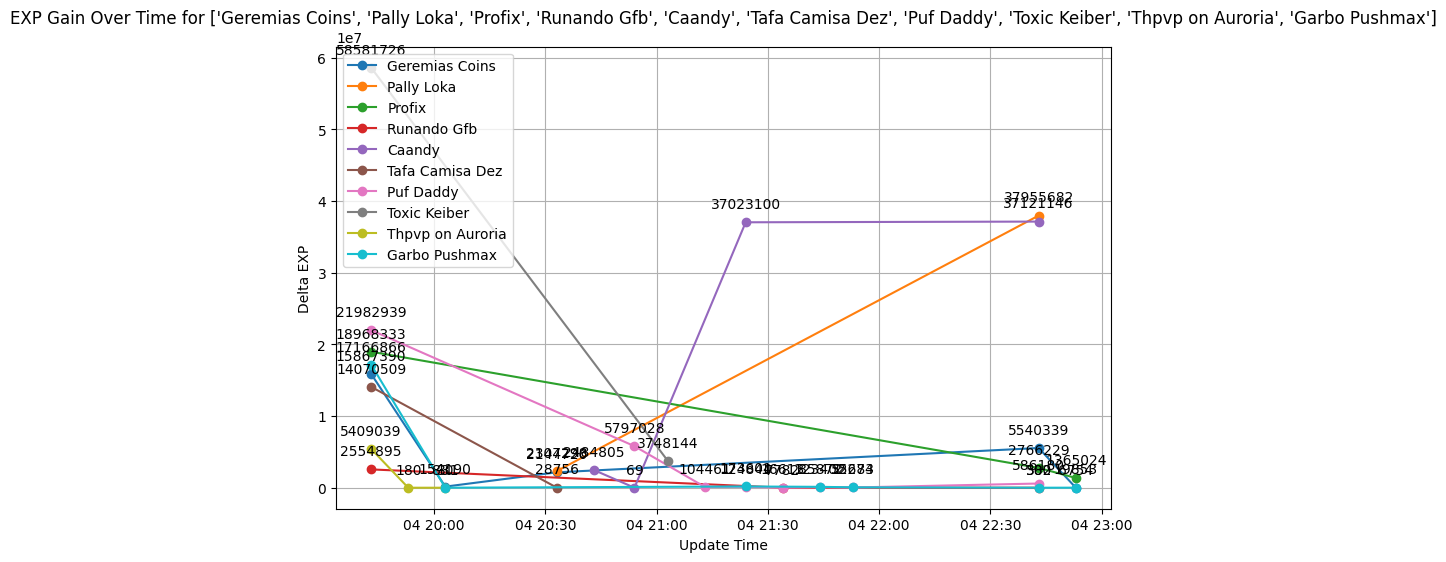

In [133]:
import matplotlib.pyplot as plt

def graph_from_name(name,db,datetime1=None,datetime2=None):
  

    table=db.deltas

    if datetime1 and datetime2:
        #convert to datetime
        table['update time']=pd.to_datetime(table['update time'])

        t=get_delta_between(datetime1,datetime2,db)
        

    t=table

    #group by name and list deltaexp and updatetime
    f=t.groupby('name').agg({'deltaexp':list,'update time':list})

    f['sum']=f['deltaexp'].apply(sum)
    f=f.sort_values('sum',ascending=False)

    f['number of updates']=f['deltaexp'].apply(len)

    if type(name)==str:
        player_data=f[f.index==name]
        plt.figure(figsize=(10,6))
        plt.plot(player_data['update time'].values[0], player_data['deltaexp'].values[0], marker='o')
        for i, txt in enumerate(player_data['deltaexp'].values[0]):
            plt.annotate(txt, (player_data['update time'].values[0][i], player_data['deltaexp'].values[0][i]), textcoords="offset points", xytext=(0,10), ha='center')
    elif isinstance(name,list):
        plt.figure(figsize=(10,6))
        for n in name:
            player_data=f[f.index==n]
            plt.plot(player_data['update time'].values[0], player_data['deltaexp'].values[0], marker='o', label=n)
            for i, txt in enumerate(player_data['deltaexp'].values[0]):
                plt.annotate(txt, (player_data['update time'].values[0][i], player_data['deltaexp'].values[0][i]), textcoords="offset points", xytext=(0,10), ha='center')
        plt.legend()
    plt.title(f'EXP Gain Over Time for {name}')
    plt.xlabel('Update Time')
    plt.ylabel('Delta EXP')
    #display numbers on points
    
    plt.grid(True)
    #buffer img
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf


all_names=db.deltas['name'].sample(10).unique().tolist()
graph_from_name(all_names,db)